In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
! pip install chart_studio

In [ ]:
import chart_studio.plotly as py

# The dataset
The dataset lists the global temperature from the eighteenth century to the year 2013 for every month, country-wise. We shall be carrying out the analyses for
- India
- Japan
- Australia

In [ ]:
df = pd.read_csv('./GlobalLandTemperaturesByCountry.csv')
df['dt'] = pd.to_datetime(df['dt'])
df = df.dropna()
data_ind = df[df["Country"] == "India"]
data_jap = df[df["Country"] == "Japan"]
data_aus = df[df["Country"] == "Australia"]

For the sake of simplicity, we shall be using the average temperatures for each month.

In [ ]:
data_ind = data_ind.drop({"AverageTemperatureUncertainty", "Country"}, 1)
data_jap = data_jap.drop({"AverageTemperatureUncertainty", "Country"}, 1)
data_aus = data_aus.drop({"AverageTemperatureUncertainty", "Country"}, 1)

<ipython-input-5-66be54ecc992>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data_ind = data_ind.drop({"AverageTemperatureUncertainty", "Country"}, 1)
<ipython-input-5-66be54ecc992>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data_jap = data_jap.drop({"AverageTemperatureUncertainty", "Country"}, 1)
<ipython-input-5-66be54ecc992>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data_aus = data_aus.drop({"AverageTemperatureUncertainty", "Country"}, 1)


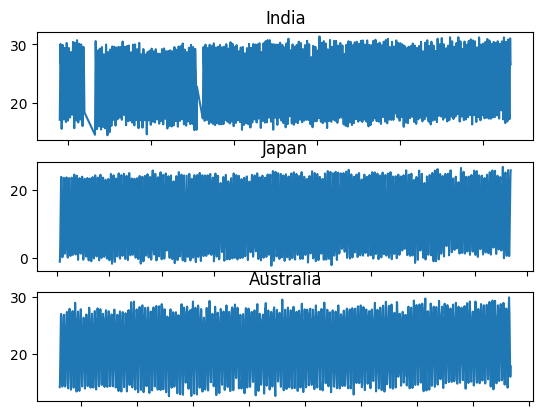

In [ ]:
fig, axs = plt.subplots(3,1)
axs[0,].plot(np.array(data_ind["dt"]), np.array(data_ind["AverageTemperature"]))
axs[0,].set_title('India')
axs[0,].xaxis.set_tick_params(labelbottom=False)
axs[1,].plot(np.array(data_jap["dt"]), np.array(data_jap["AverageTemperature"]))
axs[1,].set_title('Japan')
axs[1,].xaxis.set_tick_params(labelbottom=False)
axs[2,].plot(np.array(data_aus["dt"]), np.array(data_aus["AverageTemperature"]))
axs[2,].set_title('Australia')
axs[2,].xaxis.set_tick_params(labelbottom=False)

# Checking for stationarity
Using the Augmented Dickey Fuller Test

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from sklearn.metrics import mean_squared_error, mean_absolute_error

## India

In [ ]:
i = data_ind["AverageTemperature"].values
result = adfuller(i)
print(f'ADF Stat: {result[0]}')
print(f'p-value: {result[1]}')

ADF Stat: -4.558478434336369
p-value: 0.00015395077389037247


## Japan

In [ ]:
j = data_jap["AverageTemperature"].values
result = adfuller(j)
print(f'ADF Stat: {result[0]}')
print(f'p-value: {result[1]}')

ADF Stat: -3.864063068749569
p-value: 0.0023158316592004026


## Australia

In [ ]:
a = data_aus["AverageTemperature"].values
result = adfuller(a)
print(f'ADF Stat: {result[0]}')
print(f'p-value: {result[1]}')

ADF Stat: -4.715610985099344
p-value: 7.865030726922643e-05


# Does the data have trend?
We will try and check by fitting a linear regression model and seeing the slope. If it is close to zero, then there exists no significant trend, else there is either an increasing or decreasing trend (based on the sign of the slope)
Please note that the trend is being estimated because Global Temperature's increasing trend points to the global warming crisis.
But first we need to remove the seasonality.

A way of going about it is to average out all the values of temperature over an year and plot that. It removes the seasonality because the assumption of a seasonality is that the sum of seasonality components over the period is 0.

Now India has 2508 values, Japan has 2072 and Australia has 1930.

In [ ]:
print(2508%12, 2072%12, 1930%12)

0 8 10


In [ ]:
print(2508/12, 2064/12, 1920/12)

209.0 172.0 160.0


In [ ]:
def no_season(c, l):
    avg = []
    sum = 0
    for k in range(0, l):
        if k%12 == 0:
            sum /= 12
            avg.append(sum)
            sum = 0
        else:
            sum += c[k]
    return avg

In [ ]:
avg_i = no_season(i, 2508)
avg_j = no_season(j, 2064)
avg_a = no_season(a, 1920)
print(avg_i)

[0.0, 22.25491666666667, 21.85591666666667, 21.446166666666667, 21.64441666666666, 21.612583333333333, 22.027583333333336, 21.68825, 22.171166666666668, 21.907749999999997, 21.54366666666667, 21.823083333333333, 21.30475, 20.603583333333336, 21.416666666666668, 20.595083333333335, 20.7615, 21.065166666666666, 20.678583333333336, 20.973583333333334, 21.45091666666667, 21.891750000000002, 21.445166666666665, 21.926166666666663, 21.96733333333333, 21.76, 22.156333333333333, 21.65075, 21.588083333333334, 21.497833333333332, 21.662750000000003, 20.911666666666665, 22.092583333333337, 22.054166666666664, 21.350333333333335, 21.823999999999998, 21.744250000000005, 21.782, 21.89708333333333, 22.0415, 21.858999999999998, 21.9475, 21.92425, 21.6925, 21.988500000000002, 22.365499999999997, 22.021833333333333, 21.822916666666668, 21.89375, 22.12425, 22.07466666666667, 21.96191666666667, 22.24066666666667, 22.31958333333333, 22.402833333333334, 21.894000000000002, 21.568083333333334, 22.24025, 22.2

In [ ]:
from sklearn.linear_model import LinearRegression

## India

In [ ]:
reg = LinearRegression().fit(np.arange(209).reshape(-1, 1), avg_i)
reg.coef_

array([0.0061468])

## Japan

In [ ]:
reg = LinearRegression().fit(np.arange(172).reshape(-1, 1), avg_j)
reg.coef_

array([0.00975354])

## Australia

In [ ]:
reg = LinearRegression().fit(np.arange(160).reshape(-1, 1), avg_a)
reg.coef_

array([0.010294])

It is observed that for all the countries, the trend slope has a positive value ranging between 0.006 and 0.010. Which is bad news of course
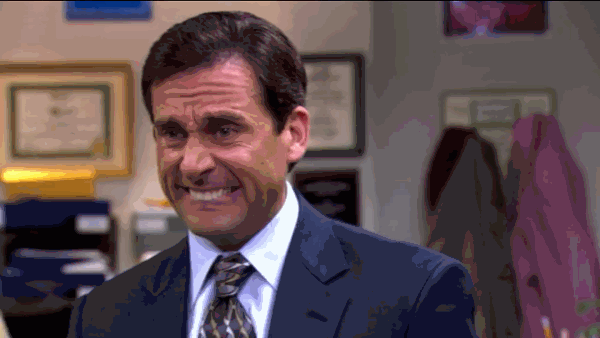

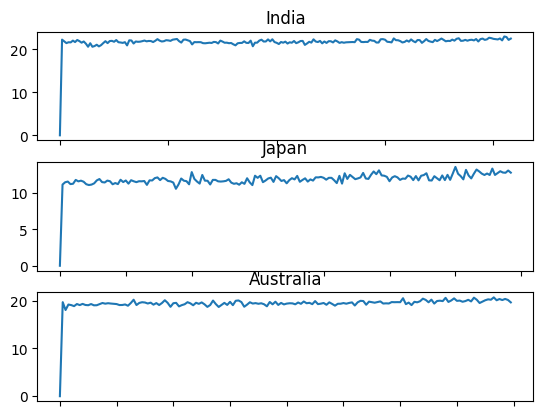

In [ ]:
fig, axs = plt.subplots(3,1)
axs[0,].plot(np.arange(209), np.array(avg_i))
axs[0,].set_title('India')
axs[0,].xaxis.set_tick_params(labelbottom=False)
axs[1,].plot(np.arange(172), np.array(avg_j))
axs[1,].set_title('Japan')
axs[1,].xaxis.set_tick_params(labelbottom=False)
axs[2,].plot(np.arange(160), np.array(avg_a))
axs[2,].set_title('Australia')
axs[2,].xaxis.set_tick_params(labelbottom=False)

# The best model

## ACF and PACF plots

###India

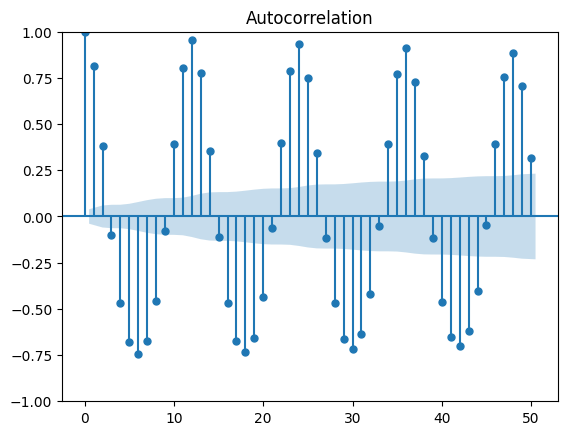

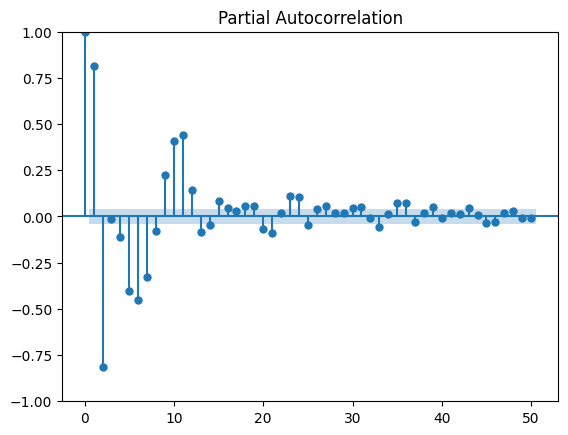

In [ ]:
plot_acf(i,lags = 50)
plot_pacf(i,lags = 50)
plt.show()

###Japan

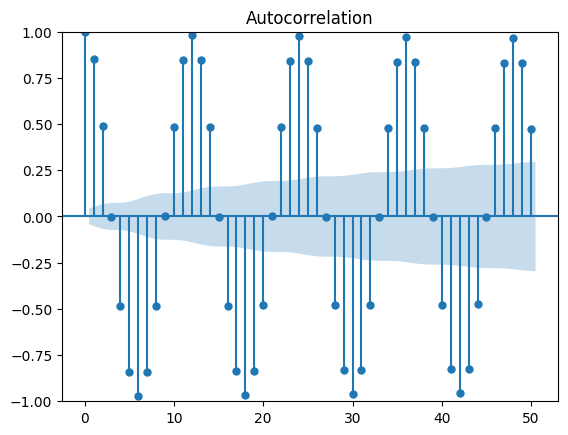

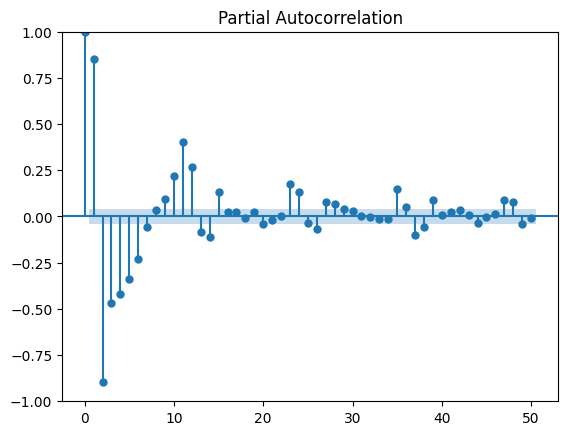

In [ ]:
plot_acf(j,lags = 50)
plot_pacf(j,lags = 50)
plt.show()

###Australia


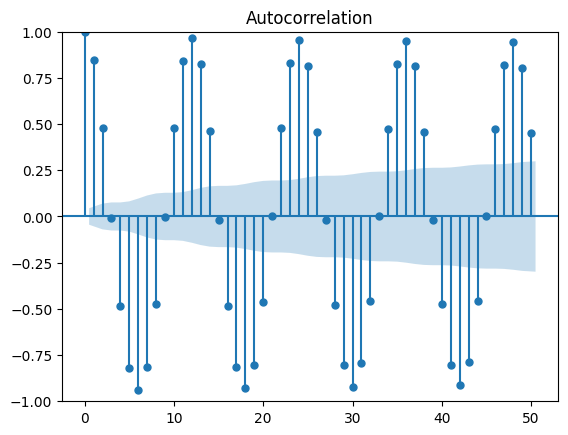

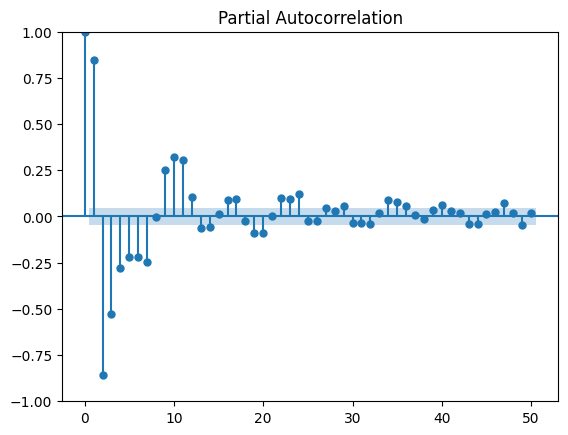

In [ ]:
plot_acf(a,lags = 50)
plot_pacf(a,lags = 50)
plt.show()

We have already deseasonalised the data for all the countries. Now since we found the trend, we must detrend it to try and see if an MA will represent it well.

## The MA

In [ ]:
navg_i = [avg_i[k] - avg_i[k-1] for k in range(1, 209)]
navg_j = [avg_j[k] - avg_j[k-1] for k in range(1, 172)]
navg_a = [avg_a[k] - avg_a[k-1] for k in range(1, 160)]

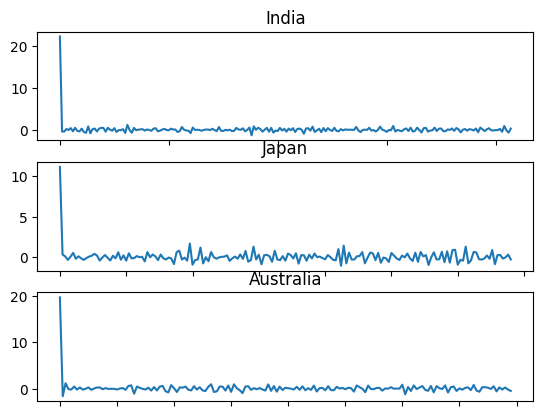

In [ ]:
fig, axs = plt.subplots(3,1)
axs[0,].plot(np.arange(208), np.array(navg_i))
axs[0,].set_title('India')
axs[0,].xaxis.set_tick_params(labelbottom=False)
axs[1,].plot(np.arange(171), np.array(navg_j))
axs[1,].set_title('Japan')
axs[1,].xaxis.set_tick_params(labelbottom=False)
axs[2,].plot(np.arange(159), np.array(navg_a))
axs[2,].set_title('Australia')
axs[2,].xaxis.set_tick_params(labelbottom=False)

In [ ]:
mean = 0
std = 1
num_samples = 216
samples = np.random.normal(mean, std, size=num_samples)

Whoaaa why did I just do that? I just generated a WN(0, 1) process. Basically an MA is a linear combination of few random variables sampled from a WN(0, $\sigma^2$) process. Hence if the data really is a moving average (pretty sure it's not), then the linear regressor should accurately be able to predict the random variables' $\theta_i$'s

In [ ]:
def ma(c, l, country):
    xs = []
    ys = []
    preds = []
    for q in range(1, 4):
        x = np.array([[samples[m-k] for k in range(-q, q)] for m in range(q, l-q)])
        y = c[q:l-q]
        reg = LinearRegression().fit(x, y)
        pred = reg.predict(x)
        xs.append(x)
        ys.append(y)
        preds.append(pred)
    fig, axs = plt.subplots(3)
    for q in range(0, 3):
        axs[q].plot(np.arange(xs[q].shape[0]), ys[q], color="red")
        axs[q].plot(np.arange(xs[q].shape[0]), preds[q], color="blue")
        axs[q].set_title(f'{country}, MA({q})')
        axs[q].xaxis.set_tick_params(labelbottom=False)
    return

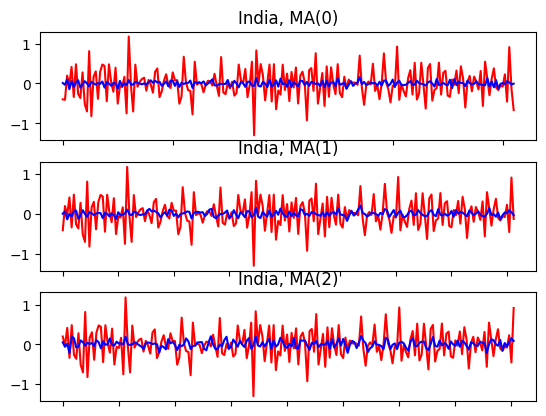

In [ ]:
ma(navg_i, 208, "India")

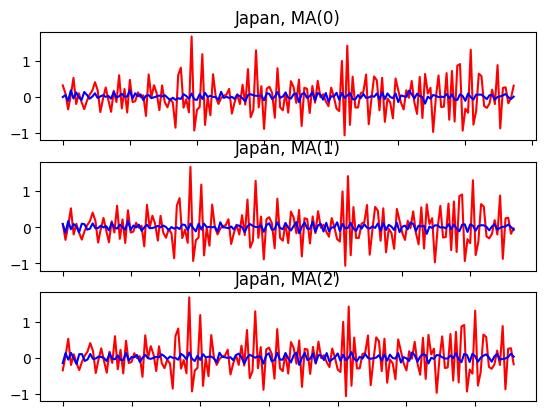

In [ ]:
ma(navg_j, 171, "Japan")

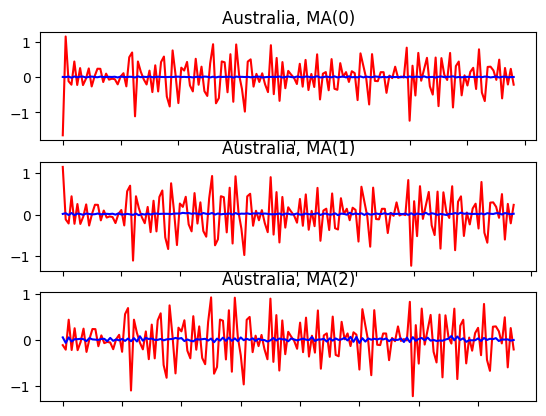

In [ ]:
ma(navg_a, 159, "Australia")

MA isn't really useful. Moreover, we know that the actual data cannot be modeled using MA, thanks to the ACF plot.



## AR process
We have figured out from the ACF that it doesn't decay over time for all of the processes. Hence it cannot be modeled at least for the original data. After the detrending and the deseasonalising, let us see if we can find an AR process for the processed data.

In [ ]:
def ar(c, l, country):
    xs = []
    ys = []
    preds = []
    for p in range(1, 4):
        x = np.array([[c[m-k] for k in range(1, p+1)] + samples[m] for m in range(p, l)])
        y = c[p:l]
        reg = LinearRegression().fit(x, y)
        pred = reg.predict(x)
        xs.append(x)
        ys.append(y)
        preds.append(pred)
    fig, axs = plt.subplots(3)
    for q in range(0, 3):
        axs[q].plot(np.arange(xs[q].shape[0]), ys[q], color="red")
        axs[q].plot(np.arange(xs[q].shape[0]), preds[q], color="blue")
        axs[q].set_title(f'{country}, AR({q})')
        axs[q].xaxis.set_tick_params(labelbottom=False)

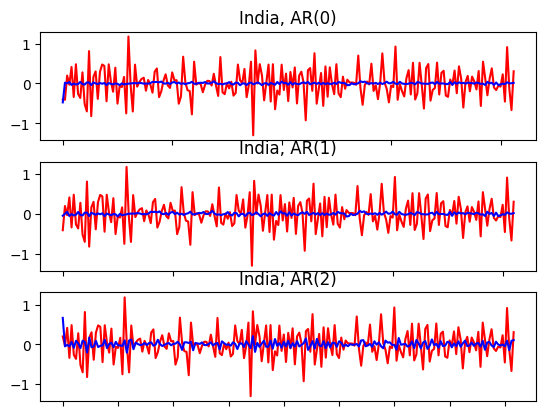

In [ ]:
ar(navg_i, 208, "India")

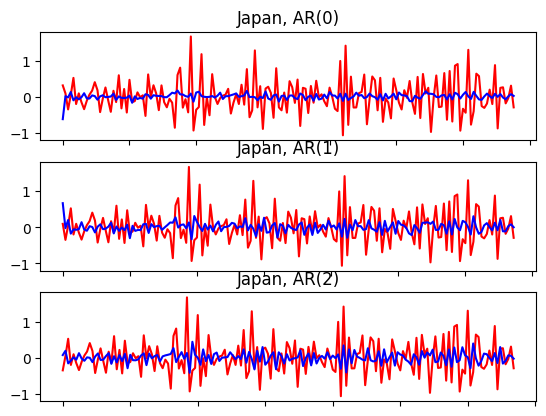

In [ ]:
ar(navg_j, 171, "Japan")

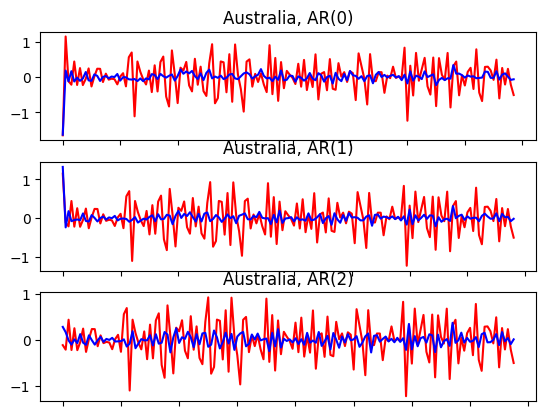

In [ ]:
ar(navg_a, 159, "Australia")

## The ARMA
Now we can try with the original dataset, since the ACF of ARMA doesn't follow any thing like a cutoff or a decay pattern. Also note that this is a stationary process if we take the threshold pvalue to be 0.01, hence this ARMA process is definitely an ARIMA process!

In order to compare the results across combinations of p and q, we will use the Akaike and Bayesian Information Criteria. They are calculated as follows:\
For $N$ samples of data points represented by $x$, with model $M$, let the maximum likelihood value be $L̂ = \max p(x | \theta\hat, M)$ and let $k$ be the number of parameters. Then,\
Akaike Information Score = $2k - 2\ln(L\hat)$ \
Bayesian Information Score = $k\ln(n) - 2\ln(L\hat)$\
References for approach: https://github.com/My-Machine-Learning-Projects/Global-Temperature-Change-Prediction/blob/master/GlobalTemperatureChangePrediction.ipynb \
References for the information criteria:
- [Akaike information criterion](https://en.wikipedia.org/wiki/Akaike_information_criterion)
- [Bayesian information criterion](https://en.wikipedia.org/wiki/Bayesian_information_criterion)

In [ ]:
def arma(c, country):
    aics = []
    bics = []
    psnqs = []

    for p in range(0, 3):
        for q in range(0, 3):

            model = ARIMA(i, order=(p, 0, q)) # since the data is stationary
            results = model.fit()
            aics.append(results.aic)
            bics.append(results.bic)
            psnqs.append((p, q))


    best_params = psnqs[aics.index(min(aics))]
    print(f"ARMA(p,q) corresponding to lowest AIC score for country {country}: ARMA{best_params}")
    return best_params

In [ ]:
pq_i = arma(i, "India")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARMA(p,q) corresponding to lowest AIC score for country India: ARMA(2, 2)


In [ ]:
pq_j = arma(j, "Japan")

ARMA(p,q) corresponding to lowest AIC score for country Japan: ARMA(2, 2)


In [ ]:
pq_a = arma(a, "Australia")

ARMA(p,q) corresponding to lowest AIC score for country Australia: ARMA(2, 2)


Now let's *see* the actually performance of the ARMA(2,2)

### India

In [ ]:
arma_modeli = ARIMA(i, order=(2, 0, 2)).fit()
preds_arma_i = arma_modeli.predict(start=0, end=len(i)-1)
mse = mean_squared_error(list(i), list(preds_arma_i))
mae = mean_absolute_error(list(i), list(preds_arma_i))
print(mse, mae)

1.8866689749025167 1.108009112888801


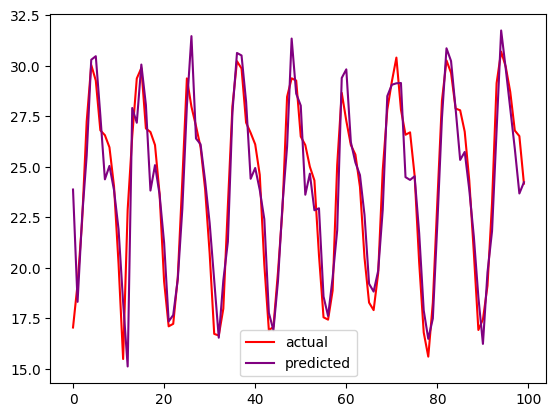

In [ ]:
plt.plot(np.arange(0, 100), i[:100], color="red", label="actual")
plt.plot(np.arange(0, 100), preds_arma_i[:100], color="purple", label="predicted")
plt.legend()
plt.show()

### Japan

In [ ]:
arma_modelj = ARIMA(j, order=(2, 0, 2)).fit()
preds_arma_j = arma_modelj.predict(start=0, end=len(j)-1)
mse_j = mean_squared_error(list(j), list(preds_arma_j))
mae_j = mean_absolute_error(list(j), list(preds_arma_j))
print(mse_j, mae_j)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1.5895905039744935 1.0025434871936652


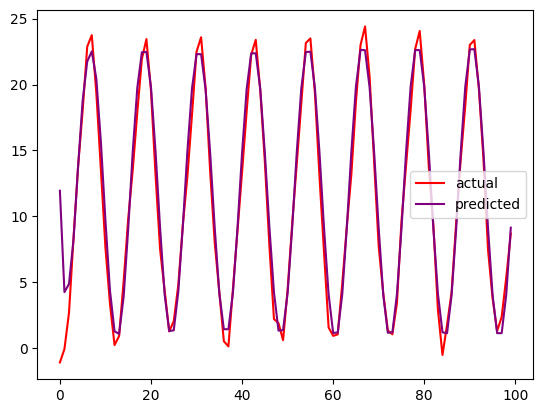

In [ ]:
plt.plot(np.arange(0, 100), j[:100], color="red", label="actual")
plt.plot(np.arange(0, 100), preds_arma_j[:100], color="purple", label="predicted")
plt.legend()
plt.show()

### Australia

In [ ]:
arma_modela = ARIMA(a, order=(2, 0, 2)).fit()
preds_arma_a = arma_modela.predict(start=0, end=len(a)-1)
mse_a = mean_squared_error(list(a), list(preds_arma_a))
mae_a = mean_absolute_error(list(a), list(preds_arma_a))
print(mse_a, mae_a)

1.081197655540619 0.807466327703222


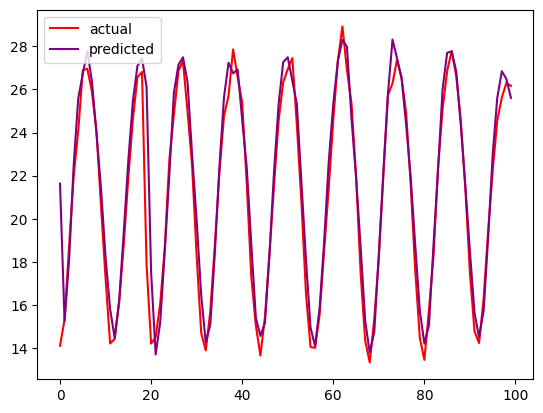

In [ ]:
plt.plot(np.arange(0, 100), a[:100], color="red", label="actual")
plt.plot(np.arange(0, 100), preds_arma_a[:100], color="purple", label="predicted")
plt.legend()
plt.show()

## QQ plots for the ARMA

In [ ]:
import statsmodels.api as sm
import pylab as py

###India

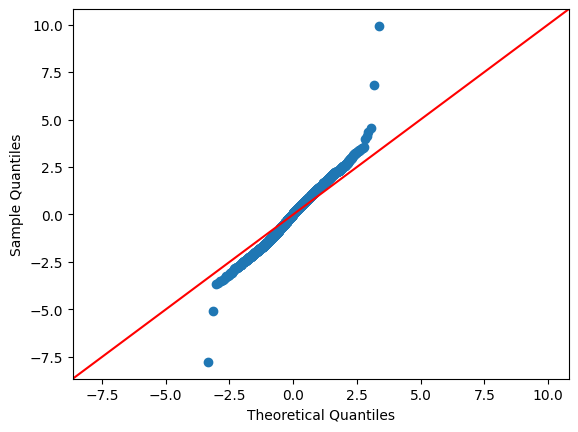

In [ ]:
q_i = np.array([preds_arma_i[k] for k in range(0, len(i))])
sm.qqplot(q_i-i, line ='45') # quantile of the data against the normal distribution
py.show()

###Japan

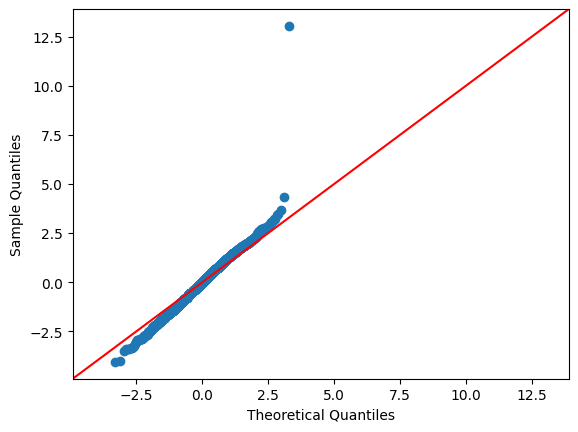

In [ ]:
q_j = np.array([preds_arma_j[k] for k in range(0, len(j))])
sm.qqplot(q_j-j, line ='45') # quantile of the data against the normal distribution
py.show()

###Australia

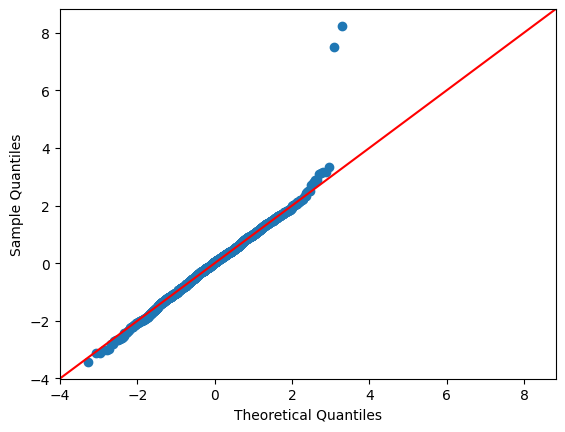

In [ ]:
q_a = np.array([preds_arma_a[k] for k in range(0, len(a))])
sm.qqplot(q_a-a, line ='45') # quantile of the data against the normal distribution

py.show()

In [ ]:
future_periods = 12*11+ 12  # You can change this to the desired number of future periods

# Use the forecast method to predict future values
forecast_values = arma_modeli.forecast(steps=future_periods)
print("Forecasted values for the next {} periods:".format(future_periods))
print(forecast_values[120:])

Forecasted values for the next 144 periods:
[23.86462624 23.87089859 23.87626748 23.87931969 23.87942622 23.87684227
 23.87255036 23.86791535 23.86426594 23.86252681 23.86299927 23.86533729
 23.8687069  23.87206647 23.87447796 23.87535905 23.87461153 23.87260189
 23.87001395 23.867627   23.86608876 23.86574708 23.86658169 23.86824552]


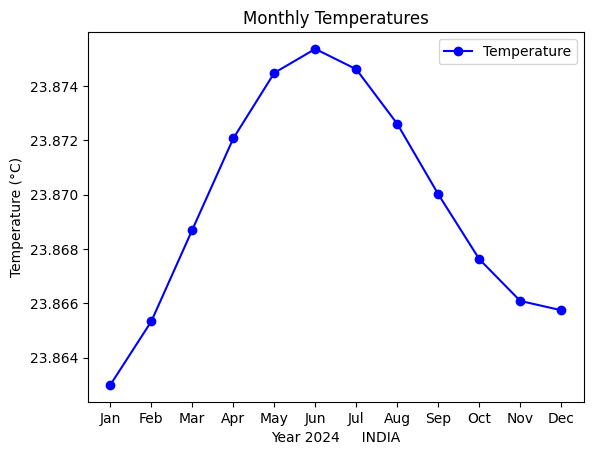

In [ ]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.plot(months,forecast_values[12*11-2:-2] , marker='o', linestyle='-', color='b', label='Temperature')

# Adding labels and title
plt.xlabel('Year 2024     INDIA')
plt.ylabel('Temperature (°C)')
plt.title('Monthly Temperatures')

# Displaying the legend
plt.legend()

# Show the plot
plt.show()

Forecasted values for the next 144 periods:
[ 3.70400556  8.54513215 14.29446556 19.41142688 22.5252131  22.80202682
 20.16834714 15.33045502  9.5850282   4.47159876  1.36002355  1.08350788]


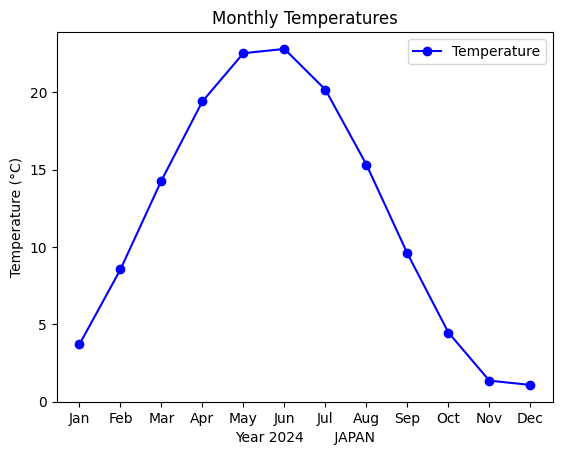

In [ ]:
future_periods = 12*11+ 12  # You can change this to the desired number of future periods

# Use the forecast method to predict future values
forecast_values = arma_modelj.forecast(steps=future_periods)
print("Forecasted values for the next {} periods:".format(future_periods))
print(forecast_values[114:126])

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.plot(months,forecast_values[114:126] , marker='o', linestyle='-', color='b', label='Temperature')

# Adding labels and title
plt.xlabel('Year 2024       JAPAN')
plt.ylabel('Temperature (°C)')
plt.title('Monthly Temperatures')

# Displaying the legend
plt.legend()

# Show the plot
plt.show()

Forecasted values for the next 144 periods:
[22.33216811 21.25358536 20.29211733 19.70300804 19.63806061 20.10663465
 20.97531894 22.00577657 22.92006221 23.47553086 23.52916591 23.074291  ]


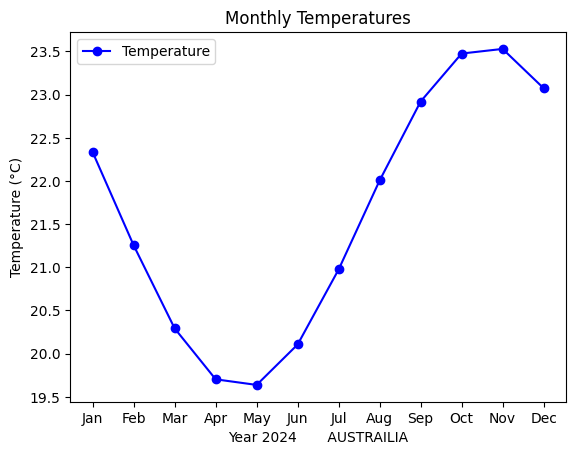

In [ ]:
future_periods = 12*11+ 12  # You can change this to the desired number of future periods

# Use the forecast method to predict future values
forecast_values = arma_modela.forecast(steps=future_periods)
print("Forecasted values for the next {} periods:".format(future_periods))
print(forecast_values[114:126])

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.plot(months,forecast_values[114:126] , marker='o', linestyle='-', color='b', label='Temperature')

# Adding labels and title
plt.xlabel('Year 2024       AUSTRAILIA')
plt.ylabel('Temperature (°C)')
plt.title('Monthly Temperatures')

# Displaying the legend
plt.legend()

# Show the plot
plt.show()